In [ ]:
from google.colab import files
files = files.upload()

Saving india_news_10000.csv to india_news_10000.csv


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("india_news_10000.csv")

In [ ]:
df.head()

,query,source,author,title,description,url,publishedAt,content
0,India,Boston Herald,Associated Press,Over 150 people are still missing after devast...,A changing climate has made northern Pakistan’...,https://www.bostonherald.com/2025/08/18/pakist...,2025-08-18T17:02:35Z,"By RIAZ KHAN\r\nPESHAWAR, Pakistan (AP) Anguis..."
1,India,The Times of India,Chidanand Rajghatta,Ukrainian President Volodymyr Zelenskyy gets d...,Donald Trump has urged Ukraine to cede territo...,https://timesofindia.indiatimes.com/world/us/z...,2025-08-18T17:02:16Z,8 simple habits that will help reduce stress o...
2,India,Antiwar.com,Dan Steinbock,The West’s Long Struggle Against Genocide Prev...,Dr. Steinbock’s highly topical new book The Ob...,https://www.antiwar.com/blog/2025/08/18/the-we...,2025-08-18T17:00:22Z,Dr. Steinbocks highly topical new book The Obl...
3,India,Livemint,Govind Choudhary,Amazon India launches massive recruitment driv...,"Amazon India is creating over 150,000 seasonal...",https://www.livemint.com/companies/amazon-indi...,2025-08-18T16:59:35Z,Amazon India has announced the creation of mor...
4,India,PBS,"Josh Boak, Associated Press, Samya Kullab, Ass...",Zelenskyy and Europe’s top leaders to meet wit...,"By arriving as a group Monday, they hope to av...",https://www.pbs.org/newshour/world/zelenskyy-a...,2025-08-18T16:59:31Z,WASHINGTON (AP) Ukraine’s future could hinge o...


In [ ]:
df.columns

Index(['query', 'source', 'author', 'title', 'description', 'url',
       'publishedAt', 'content'],
      dtype='object')

In [ ]:
df.isnull().sum()

,0
query,0
source,0
author,46
title,0
description,13
url,0
publishedAt,0
content,1


In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', str(text))
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["title"] = df["title"].astype(str).apply(clean_text)
df["content"] = df["content"].astype(str).apply(clean_text)
df = df[df["title"].str.strip() != ""].reset_index(drop=True)
print("After cleaning rows:", len(df))

After cleaning rows: 926


In [ ]:
MODEL_NAME = "all-MiniLM-L6-v2"
model = SentenceTransformer(MODEL_NAME)
print("Loaded model:", MODEL_NAME)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded model: all-MiniLM-L6-v2


In [ ]:
def chunk_text(text, max_chars=450):
    """Split text into chunks of ~max_chars without cutting words."""
    if not text:
        return []
    text = text.strip()
    if len(text) <= max_chars:
        return [text]
    chunks = []
    start = 0
    L = len(text)
    while start < L:
        end = min(L, start + max_chars)
        if end < L:
            last_space = text.rfind(" ", start, end)
            if last_space > start:
                end = last_space
        chunks.append(text[start:end].strip())
        start = end
    return chunks


In [ ]:
titles = df["title"].tolist()
title_embs = model.encode(titles, convert_to_numpy=True, show_progress_bar=True, batch_size=64)

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
content_embs = []
contents = df["content"].tolist()
for txt in tqdm(contents, desc="Embedding contents"):
    chunks = chunk_text(txt, max_chars=450)
    if len(chunks) == 0:
        # fallback zero vector
        content_embs.append(np.zeros(title_embs.shape[1], dtype=float))
        continue
    chunk_embs = model.encode(chunks, convert_to_numpy=True, show_progress_bar=False)
    # mean pool the chunk embeddings
    content_embs.append(np.mean(chunk_embs, axis=0))

Embedding contents:   0%|          | 0/926 [00:00<?, ?it/s]

In [ ]:
content_embs = np.vstack(content_embs)
print("Embeddings shapes:", title_embs.shape, content_embs.shape)

Embeddings shapes: (926, 384) (926, 384)


In [ ]:
sims = np.array([
    cosine_similarity(title_embs[i].reshape(1,-1), content_embs[i].reshape(1,-1))[0,0]
    for i in range(len(df))
])
df["similarity"] = sims
print(df["similarity"].describe())

count    926.000000
mean       0.575423
std        0.225426
min       -0.109037
25%        0.441380
50%        0.627005
75%        0.748691
max        0.972077
Name: similarity, dtype: float64


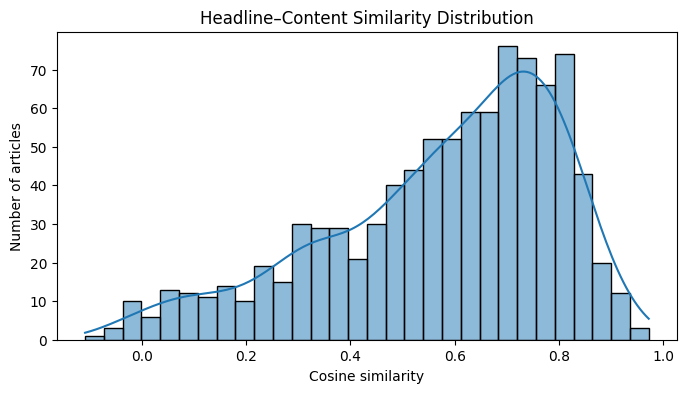

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df["similarity"], bins=30, kde=True)
plt.title("Headline–Content Similarity Distribution")
plt.xlabel("Cosine similarity")
plt.ylabel("Number of articles")
plt.show()

In [ ]:
k = 10
low = df.nsmallest(k, "similarity")[["title","similarity","source","publishedAt","url"]]
print(f"\nTop {k} lowest-similarity articles (potential clickbait):")
pd.options.display.max_colwidth = 120
print(low.to_string(index=False))


Top 10 lowest-similarity articles (potential clickbait):
                                                                                                                                                        title  similarity             source          publishedAt                                                                                                                                                                   url
                                                                       maharashtra sec asks eci to delay voter roll revision until after local body elections   -0.109037 The Times of India 2025-08-17T07:05:16Z      https://economictimes.indiatimes.com/news/india/maharashtra-sec-asks-eci-to-delay-voter-roll-revision-until-after-local-body-elections/articleshow/123343391.cms
                                                                                                                                            letters to editor   -0.069606       BusinessLine 2

In [ ]:
for idx, row in df.nsmallest(8, "similarity").iterrows():
    print(f"---\nScore: {row['similarity']:.3f} | Source: {row.get('source')} | Date: {row.get('publishedAt')}")
    print("Title:", row["title"])
    print("Snippet:", (row["content"] or "")[:400].replace('\n',' ') + "...\n")

---
Score: -0.109 | Source: The Times of India | Date: 2025-08-17T07:05:16Z
Title: maharashtra sec asks eci to delay voter roll revision until after local body elections
Snippet: investment ideas grow your wealth with stock ideas &amp; sectoral trends. stock reports plus buy low &amp; sell high with access to stock score, upside potential &amp; more. bigbull portfolio g… [+439 chars]...

---
Score: -0.070 | Source: BusinessLine | Date: 2025-08-15T15:20:13Z
Title: letters to editor
Snippet: that us and china extended the tariff truce deadline for each other till november 10 shows the ice between them has considerably melted. of course, china attracts 30 per cent levy during the interreg… [+2858 chars]...

---
Score: -0.069 | Source: Biztoc.com | Date: 2025-08-17T04:05:42Z
Title: erin downgraded to formidable category 4 hurricane, nhc says
Snippet: { window.open(this.href, '_blank'); }, 200); return false;"&gt;why might google have to sell chrome? { window.open(this.href, '_blank'); }, 2

In [ ]:
if "source" in df.columns and df["source"].notna().any():
    src_stats = df.groupby("source")["similarity"].agg(["mean","count"]).sort_values("mean", ascending=False)
    print("\nAverage similarity by source (top rows):")
    print(src_stats.head(20))


Average similarity by source (top rows):
                                  mean  count
source                                       
Skepticalscience.com          0.939486      1
Benzinga                      0.937854      1
Thegatewithbriancohen.com     0.929532      1
Samsung.com                   0.924424      1
Thefutoncritic.com            0.920553      1
Japan Today                   0.874632      1
National Observer             0.837795      2
Power Technology              0.822870      1
TalkAndroid                   0.821697      1
Council on Foreign Relations  0.818962      1
Greater Kashmir               0.811361      1
Insurance Journal             0.809203      1
ETF Daily News                0.808066     11
Infosecurity Magazine         0.807334      1
ABC News                      0.803542      1
News18                        0.799421      2
ExchangeWire                  0.798802      1
Upenn.edu                     0.789361      1
TheStreet                     0.781028

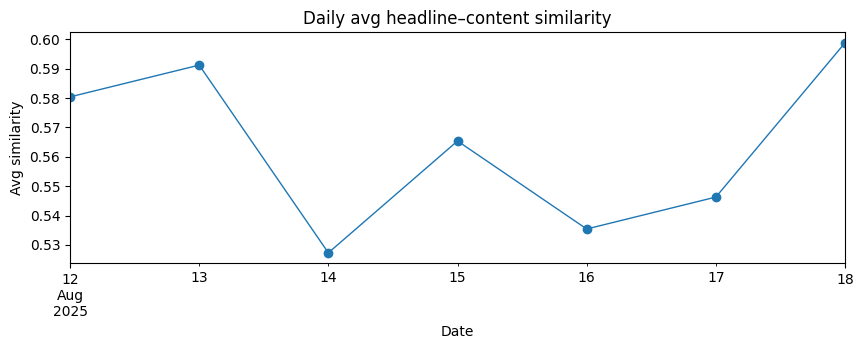

In [ ]:
if "publishedAt" in df.columns:
    df["publishedAt_dt"] = pd.to_datetime(df["publishedAt"], utc=True, errors="coerce")
    daily = (df.dropna(subset=["publishedAt_dt"])
               .set_index("publishedAt_dt")
               .resample("D")["similarity"]
               .mean().dropna())
    if len(daily) > 0:
        plt.figure(figsize=(10,3))
        daily.plot(marker="o", linewidth=1)
        plt.title("Daily avg headline–content similarity")
        plt.xlabel("Date")
        plt.ylabel("Avg similarity")
        plt.show()

In [ ]:
#fixed threshold
THRESHOLD = 0.45
df["is_clickbait_candidate"] = df["similarity"] < THRESHOLD

# percentile-based
pctl = 0.05
cut = df["similarity"].quantile(pctl)
df["is_clickbait_bottom5pct"] = df["similarity"] <= cut

print(f"Fixed threshold {THRESHOLD}: {df['is_clickbait_candidate'].sum()} candidates")
print(f"Bottom {int(pctl*100)}% threshold ({cut:.3f}): {df['is_clickbait_bottom5pct'].sum()} candidates")


Fixed threshold 0.45: 240 candidates
Bottom 5% threshold (0.110): 47 candidates


In [ ]:
# pick bottom 25% as "low" for clustering
low_mask = df["similarity"] <= df["similarity"].quantile(0.25)
low_idxs = np.where(low_mask)[0]
if len(low_idxs) >= 5:
    # use title embeddings for clustering (faster)
    low_title_embs = title_embs[low_idxs]
    # reduce dims
    pca = PCA(n_components=min(20, low_title_embs.shape[1])).fit_transform(low_title_embs)
    K = min(6, max(2, len(low_idxs)//20))  # heuristic for k
    km = KMeans(n_clusters=K, random_state=42).fit(pca)
    clusters = km.labels_
    # attach cluster labels
    low_df = df[low_mask].copy().reset_index(drop=True)
    low_df["cluster"] = clusters
    # show sample titles per cluster
    for c in sorted(low_df["cluster"].unique()):
        sample = low_df[low_df["cluster"]==c].head(6)
        print(f"\nCluster {c} (n={len(low_df[low_df['cluster']==c])}):")
        for t in sample["title"].tolist():
            print(" -", t[:140])
else:
    print("Not enough low-similarity items to cluster.")



Cluster 0 (n=42):
 - retail’s future hinges on tech agility, says sap’s andré bechtold
 - we are not dependent on heavy trucks alone and diversified into other businesses, says ashok leyland chairman
 - sports bill bats for fresh faces in federations
 - aap's student wing to back deserving du candidates lacking funds for union polls
 - sensex and nifty ripe for a short-term rebound, says jefferies, picks 8 stocks
 - chase is dropping a transfer partner – 3 reasons why i’m not worried…

Cluster 1 (n=45):
 - pakistan floods: hundreds killed within days in rain-related incidents - bbc
 - why moving away from dei reinforces the proverbial glass ceiling
 - ca foundation, intermediate & final september exams: admit cards available now on icai portal, step-by-step download guide
 - official trailer for joe wright's 'mussolini: son of the century' series
 - letters to editor
 - roadzen addresses inaccurate reporting of analyst expectations in q1 fy2026 results

Cluster 2 (n=41):
 - ukrainian 

In [ ]:
OUT_CSV = "news_similarity_results.csv"
df.to_csv(OUT_CSV, index=False)
print("Saved results to", OUT_CSV)

df[df["is_clickbait_candidate"]].to_csv("clickbait_candidates.csv", index=False)


Saved results to news_similarity_results.csv


In [ ]:
# app.py
import streamlit as st
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer("all-MiniLM-L6-v2")

st.title("Headline - Content Similarity Checker")
title = st.text_input("Headline")
content = st.text_area("Content / Article text", height=300)
if st.button("Check similarity"):
    t_emb = model.encode([title], convert_to_numpy=True)
    # chunk content quickly
    def chunk_text_simple(text, max_chars=450):
        if len(text)<=max_chars: return [text]
        out=[]; i=0
        while i<len(text):
            out.append(text[i:i+max_chars])
            i+=max_chars
        return out
    chunks = chunk_text_simple(content)
    c_emb = model.encode(chunks, convert_to_numpy=True)
    c_emb_mean = c_emb.mean(axis=0, keepdims=True)
    sim = util.cos_sim(t_emb, c_emb_mean).item()
    st.metric("Cosine similarity", f"{sim:.3f}")
    if sim < 0.45:
        st.warning("Low similarity — headline might be clickbait or poorly representative.")
    else:
        st.success("Headline appears aligned with the content.")


ModuleNotFoundError: No module named 'streamlit'